In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import svm 
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import itertools

pca_sklearn = 0

In [43]:
def dataFill(data):
    #print(data.isnull().sum())
    ### data fill ###
    #dt = data.fillna(method='ffill')
    #dt = dt.fillna(method='bfill')
    print("before dataFill data.shape:", data.shape)
    thresh_axis0 = data.shape[1] * 0.1
    thresh_axis1 = data.shape[0] * 0.6
    print("thresh_axis0, thresh_axis1:", thresh_axis0, thresh_axis1)
    dt = data.dropna(axis=1, thresh=thresh_axis1)
    dt = dt.dropna(thresh=thresh_axis0)
    dt = dt.fillna(data.mean())
    print("after dataFill dt.shape:", dt.shape)
    #print(dt.index)
    #print(dt.columns)
    return dt

def dataScale(dt):
    from sklearn.preprocessing import StandardScaler
    for column in dt.columns[2:]:
        #print(column, dt[column].max(), dt[column].min(), dt[column].max()-dt[column].min())
        if dt[column].max()-dt[column].min() == 1:
            dt[column] = (dt[column] - dt[column].min())/(dt[column].max() - dt[column].min())
        else:
            dt[column] = StandardScaler().fit_transform(dt[column].reshape(-1, 1))
    return dt

def dataExtract(dt):
    #X = dt.ix[:, dt.columns != ('y' and  'user_id')]
    #y = dt.ix[:, dt.columns == 'y']
    X = dt.columns.tolist()
    X = X[5:]
    print("X:", X)
    X = dt[X]
    y = dt[["y"]]
    #print(X.head())
    #print(y.head())
    return X, y

def downSample(dt):
    ### 下采样 ###
    #统计异常样本数目和索引
    number_records_fraud = len(dt[dt.y == 3]) 
    print("number_fraud:", number_records_fraud)
    fraud_indices = np.array(dt[dt.y == 3].index)
    red_indices = dt[dt.y == 0].index
    normal_indices = dt[dt.y == 1].index
    yellow_indices = dt[dt.y == 2].index
    #print("normal_indices:", normal_indices)
    #random模块，随机选择和异常事件一样多的正常数据
    random_red_indices = np.random.choice(red_indices, number_records_fraud, replace = False)
    random_red_indices = np.array(random_red_indices)
    random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
    random_normal_indices = np.array(random_normal_indices)
    random_yellow_indices = np.random.choice(yellow_indices, number_records_fraud, replace = False)
    random_yellow_indices = np.array(random_yellow_indices)
    #合并异常和正常的数据集
    under_sample_indices = np.concatenate([fraud_indices,random_normal_indices,random_red_indices,random_yellow_indices])
    under_sample_dt = dt.iloc[under_sample_indices,:]
    #X_undersample = under_sample_dt.ix[:, under_sample_dt.columns != 'y']
    X_undersample = under_sample_dt.ix[:, 2:] 
    y_undersample = under_sample_dt.ix[:, under_sample_dt.columns == 'y']
    print("Percentage of normal transactions: ", len(under_sample_dt[under_sample_dt.y == 0])/len(under_sample_dt))
    print("Percentage of fraud transactions: ", len(under_sample_dt[under_sample_dt.y == 1])/len(under_sample_dt))
    print("Total number of transactions in resampled dt: ", len(under_sample_dt))
    return X_undersample, y_undersample

def overSample(X, y):
    ### oversample ###
    features_train, features_test, labels_train, labels_test = train_test_split(X,
                                                                                y,
                                                                                test_size=0,
                                                                                random_state=0)
    oversampler=SMOTE(random_state=0)  #实例化参数，只对训练集增广，测试集不动  
    #os_features,os_labels=oversampler.fit_sample(features_train,labels_train)# 使 0 和 1 样本相等  
    os_features,os_labels=oversampler.fit_sample(X, y)# 使 0 和 1 样本相等  
    X_sample = pd.DataFrame(os_features)
    y_sample = pd.DataFrame(os_labels)
    return X_sample, y_sample

def my_PCA(data):#data without target, just train data, withou train target.  
    from sklearn import decomposition  
    dt = 0 
    n = PCA_INIT_N
    print("before PCA data.shape:", data.shape)
    global pca_sklearn
    while n <= data.shape[1]:
        pca_sklearn = decomposition.PCA(n_components=n)  
        dt = pca_sklearn.fit_transform(data)  
        main_var = pca_sklearn.explained_variance_  
        #print(pca_sklearn.explained_variance_ratio_)
        #print(pca_sklearn.explained_variance_)
        sum_var = sum(main_var)
        print("n, sum_var:", n, sum_var)
        #n = 15  
        #plt.plot(main_var[:n])  
        if sum_var > SUM_MAIN_VAR:
            return dt
        n += 1
    print("after PCA data.shape:", dt.shape)
    return dt



In [44]:
def dataAnalysis(data):
    data = dataFill(data)
    #print(data.dtypes)
    print(data.select_dtypes(include=['float64']).describe())
    print(data.groupby('y').describe())
    
    print(data.A[data.y==1].describe())
    print(data.A[data.y==0].describe())
    print(data.corr())
    
    print(data.groupby('y').size())

    for column in data.columns[2:]:
        print ("columns:", column)

        f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, sharex=True, figsize=(12,12))
        bins = 50
        ax1.hist(data[column][data.y == 0], bins = bins, facecolor='red')
        ax1.set_title('Red')
        ax2.hist(data[column][data.y == 1], bins = bins, facecolor='green')
        ax2.set_title('Normal')
        ax3.hist(data[column][data.y == 2], bins = bins, facecolor='yellow')
        ax3.set_title('Yellow')
        ax4.hist(data[column][data.y == 3], bins = bins, facecolor='cyan')
        ax4.set_title('Cyan')
        ax5.hist(data[column][data.y == 4], bins = bins, facecolor='blue')
        ax5.set_title('White')
        ax6.hist(data[column][data.y == 5], bins = bins, facecolor='black')
        ax6.set_title('Black')

        plt.xlabel(column)
        plt.ylabel('Numbers')
        plt.show()
    
    #count_classes = pd.y.value_counts(sort = True).sort_index()
    #count_classes.plot(kind = 'bar')
    #plt.title("data")
    #plt.xlabel("y")
    #plt.ylabel("Freq")
    #plt.show()


In [45]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def calcConfMatrix(y_test_ori, y_predict): 
    # 计算混淆矩阵
    cnf_matrix = confusion_matrix(y_test_ori, y_predict)
    np.set_printoptions(precision=2)
    print(cnf_matrix)
    #print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
    
    # 非归一化混淆矩阵
    class_names = [0,1]
    plt.figure()
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Confusion matrix')


def classifyReport(y_test_ori, y_predict):
    # 分类报告：precision/recall/fi-score/均值/分类个数
    from sklearn.metrics import classification_report
    target_names = ['class 0', 'class 1', 'class2', 'class3']
    print(classification_report(y_test_ori, y_predict, target_names=target_names))
    
def calKappaScore(y_test_ori, y_predict):
    # Kappa score
    from sklearn.metrics import cohen_kappa_score
    kappa_score = cohen_kappa_score(y_test_ori, y_predict)
    print("kappa_score:", kappa_score)

def plotROC(y_test_ori, y_predict, i, color):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_ori, y_predict)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot ROC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r-')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])


import xgboost as xgb
from xgboost.sklearn import XGBClassifier, XGBRegressor

XGBC = xgb.XGBClassifier(
    #gamma = 0.1,                      # Gamma指定了节点分裂所需的最小损失函数下降值，值越大，算法越保守。  
    #learning_rate = 0.3,              # 学习速率  
    #max_delta_step = 0,               # 限制每棵树权重改变的最大步长。0为没有限制，越大越保守。可用于样本不平衡的时候。  
    #max_depth = 5,                    # 树的最大深度  
    #min_child_weight = 6,             # 最小叶子节点样本权重和。低避免过拟合，太高导致欠拟合。  
    #missing = None,                   # 如果有缺失值则替换。默认 None 就是 np.nan  
    #n_estimators = 250,               # 树的数量  
    #nthread = 8,                      # 并行线程数量  
    #objective = 'binary:logistic',    # 指定学习任务和相应的学习目标或要使用的自定义目标函数  

    gamma = 0.1,                      # Gamma指定了节点分裂所需的最小损失函数下降值，值越大，算法越保守。  
    learning_rate = 0.3,              # 学习速率  
    max_delta_step = 0,               # 限制每棵树权重改变的最大步长。0为没有限制，越大越保守。可用于样本不平衡的时候。  
    max_depth = 5,                    # 树的最大深度  
    min_child_weight = 6,             # 最小叶子节点样本权重和。低避免过拟合，太高导致欠拟合。  
    missing = None,                   # 如果有缺失值则替换。默认 None 就是 np.nan  
    n_estimators = 250,               # 树的数量  
    nthread = 8,                      # 并行线程数量  
    objective = 'binary:logistic',    # 指定学习任务和相应的学习目标或要使用的自定义目标函数  
    #'objective':'multi:softprob',    # 定义学习任务及相应的学习目标  
    #'objective':'reg:linear',        # 线性回归  
    #'objective':'reg:logistic',      # 逻辑回归  
    #'objective':'binary:logistic',   # 二分类的逻辑回归问题，输出为概率  
    #'objective':'binary:logitraw',   # 二分类的逻辑回归问题，输出结果为 wTx，wTx指机器学习线性模型f(x)=wTx+b  
    #'objective':'count:poisson'      # 计数问题的poisson回归，输出结果为poisson分布  
    #objective = 'multi:softmax',      # 让XGBoost采用softmax目标函数处理多分类问题，同时需要设置参数num_class  
    #'objective':'multi:softprob'     # 和softmax一样，但是输出的是ndata * nclass的向量，  
                                      # 可以将该向量reshape成ndata行nclass列的矩阵。  
                                      # 每行数据表示样本所属于每个类别的概率。  
    reg_alpha = 1,                    # 权重的L1正则化项。默认1  
    reg_lambda = 1,                   # 权重的L2正则化项。默认1  
    scale_pos_weight = 10000,         # 数字变大，会增加对少量诈骗样本的学习权重，这里10000比较好  
    seed = 0,                         # 随机种子  
    silent = True,                    # 静默模式开启，不会输出任何信息  
    subsample = 0.9,                  # 控制对于每棵树，随机采样的比例。减小会更加保守，避免过拟,过小会导致欠拟合。  
    base_score = 0.5)                 # 所有实例的初始预测评分,全局偏差   

def plot_hyperplane(clf, X, y, 
                    h=0.02, 
                    draw_sv=True, 
                    title='hyperplan'):
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    plt.title(title)
    #plt.xlim(xx.min(), xx.max())
    #plt.ylim(yy.min(), yy.max())
    #plt.xticks(())
    #plt.yticks(())

    #Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    #Z = Z.reshape(xx.shape)
    #plt.contourf(xx, yy, Z, cmap='hot', alpha=0.5)

    markers = ['o', 's', '^', '*']
    colors = ['r', 'b', 'y', 'c']
    labels = np.unique(y)
    for label in labels:
        plt.scatter(X[y==label][:, 0], 
                    X[y==label][:, 1], 
                    color=colors[int(label)],
                    marker=markers[int(label)], s=20)
    if draw_sv:
        sv = clf.support_vectors_
        print sv
        plt.scatter(sv[:, 0], sv[:, 1], c='black', marker='x', s=15)




<module 'posixpath' from '/usr/lib/python2.7/posixpath.pyc'>
('before dataFill data.shape:', (694, 11))
('thresh_axis0, thresh_axis1:', 1.1, 416.4)
('after dataFill dt.shape:', (694, 11))
                R           G          B1           L           A           B  \
count  694.000000  694.000000  694.000000  694.000000  694.000000  694.000000   
mean   171.106661  147.428386  130.915974  144.633046  137.158549  143.425736   
std     22.455248   21.687570   25.020309   22.292163    3.029431    6.304384   
min    100.229000   88.597000   65.444000   85.445300  128.958000  127.456000   
25%    154.720500  129.937250  111.446000  127.714000  135.200500  139.023000   
50%    169.854000  147.111500  130.544500  143.272000  137.341500  143.986500   
75%    187.701750  163.649250  148.660750  161.327000  139.067000  147.999250   
max    226.767000  210.305000  204.132000  195.828000  147.238000  165.070000   

                H           S           V  
count  694.000000  694.000000  694.000

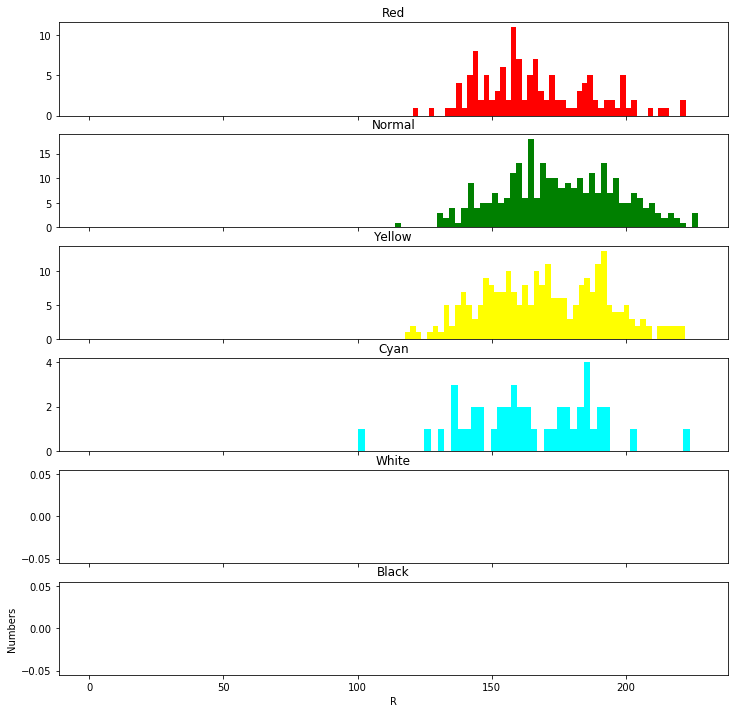

('columns:', 'G')


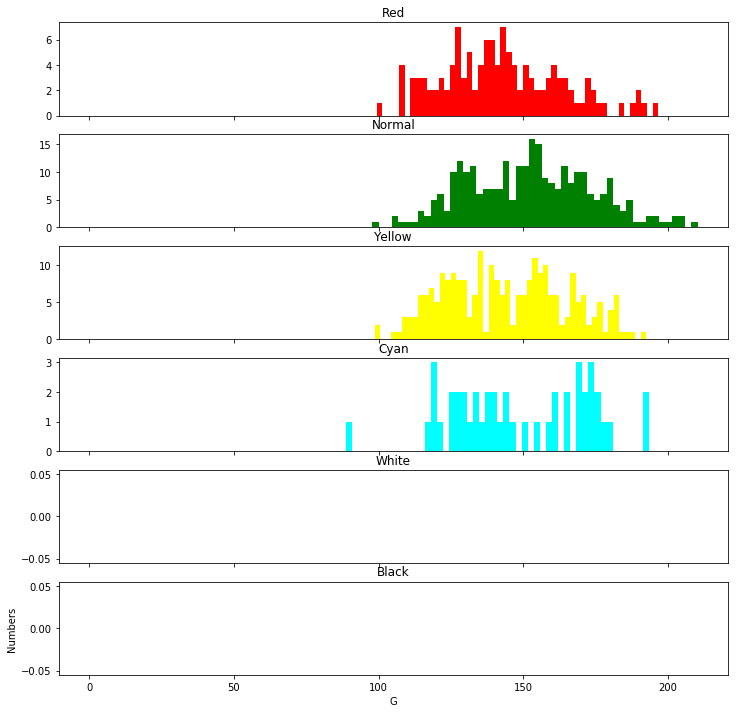

('columns:', 'B1')


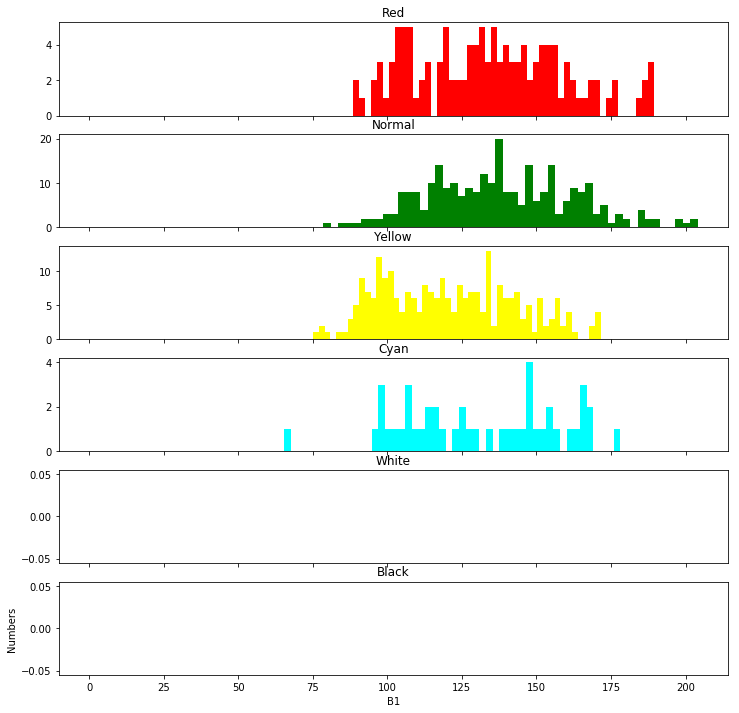

('columns:', 'L')


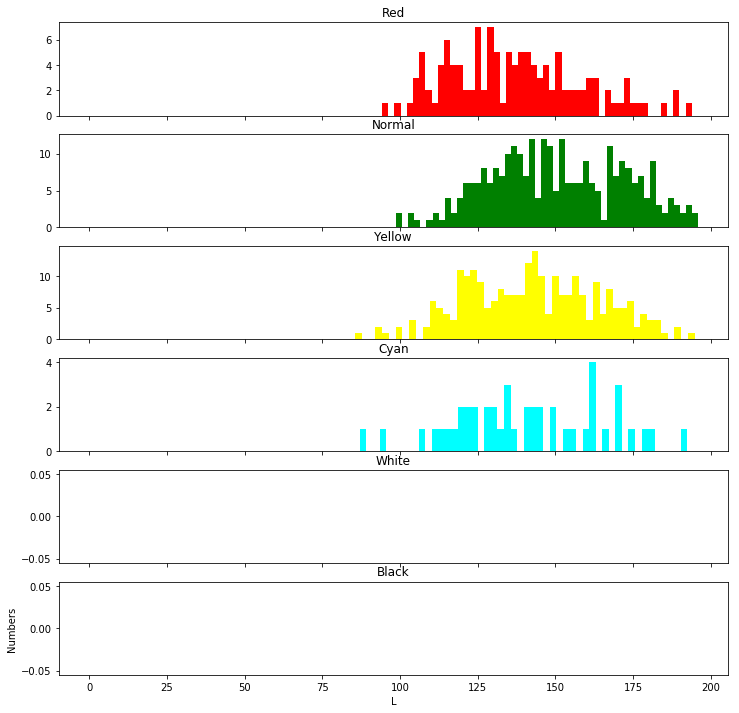

('columns:', 'A')


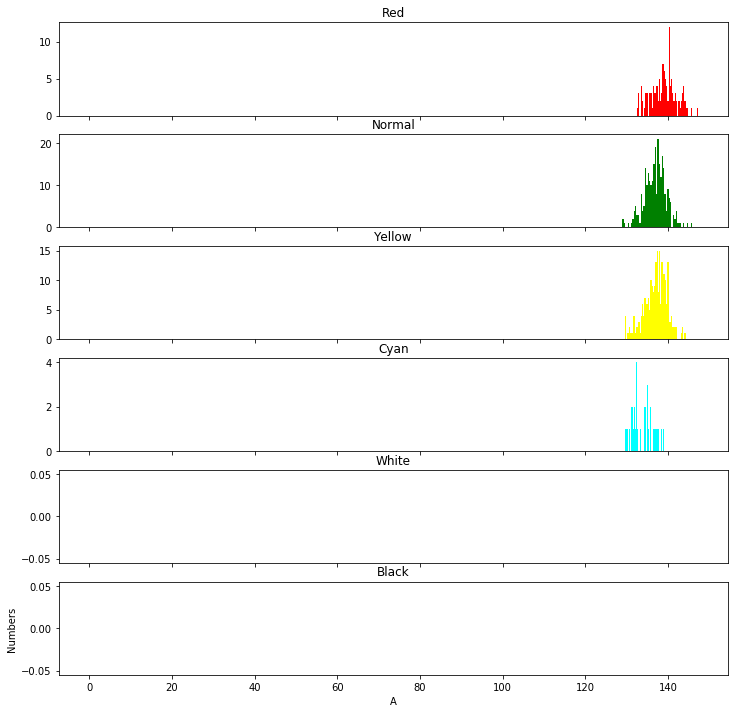

('columns:', 'B')


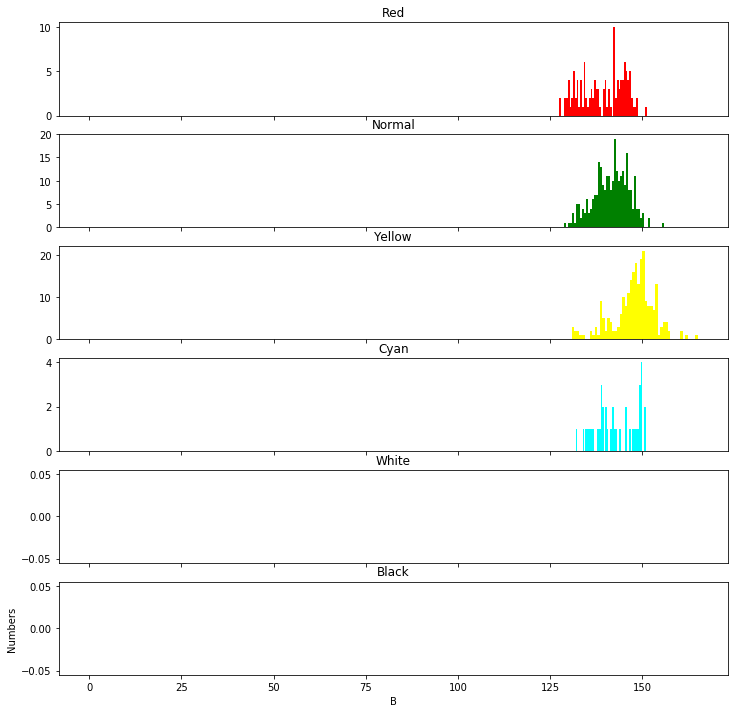

('columns:', 'H')


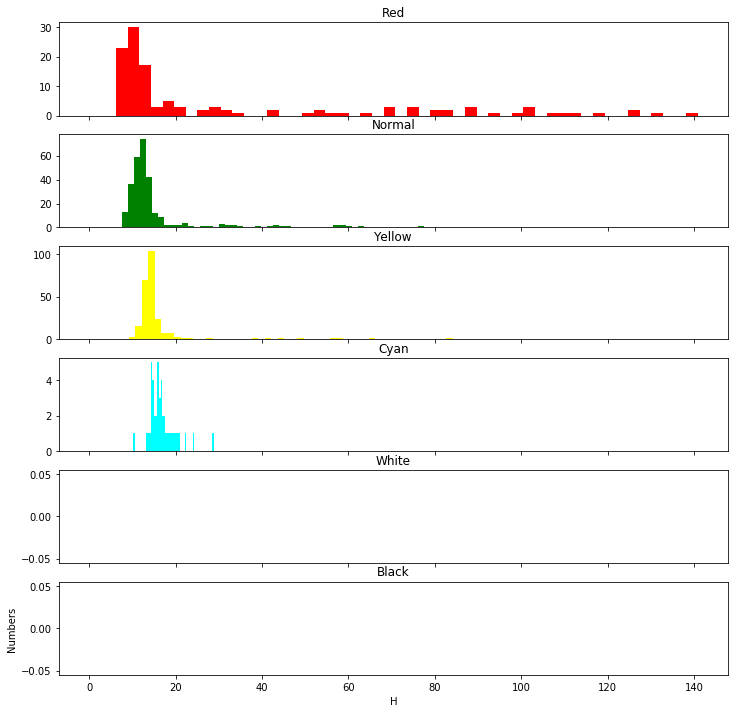

('columns:', 'S')


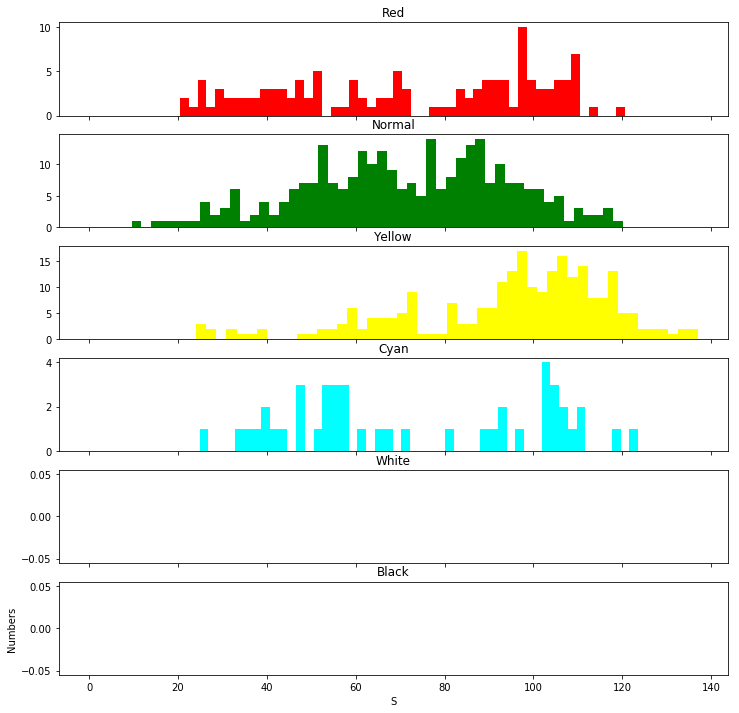

('columns:', 'V')


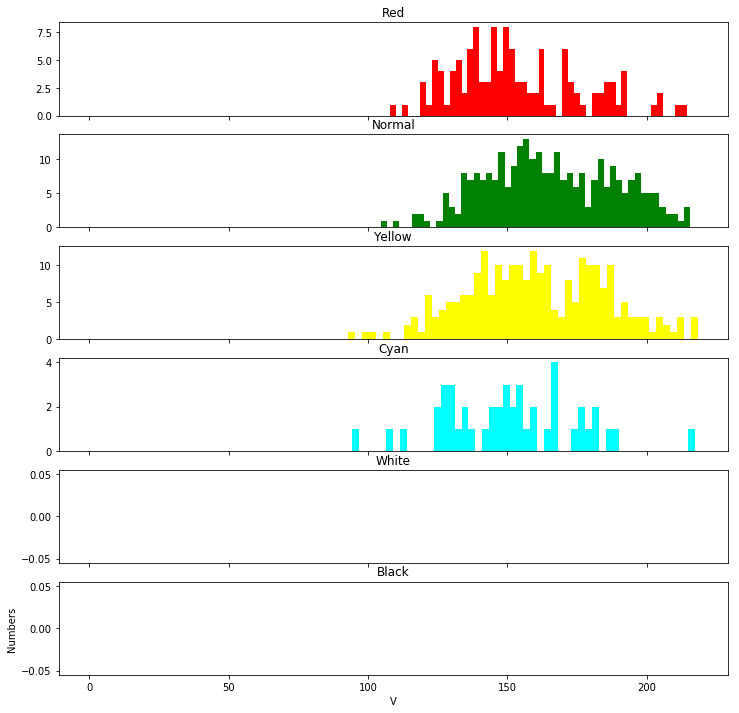

('before dataFill data.shape:', (694, 11))
('thresh_axis0, thresh_axis1:', 1.1, 416.4)
('after dataFill dt.shape:', (694, 11))
('X:', ['L', 'A', 'B', 'H', 'S', 'V'])
('before dataFill data.shape:', (694, 11))
('thresh_axis0, thresh_axis1:', 1.1, 416.4)
('after dataFill dt.shape:', (694, 11))
('X:', ['L', 'A', 'B', 'H', 'S', 'V'])
('X_v.shape:', (694, 6))


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [46]:
import os
print os.path
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',100000)
data = pd.read_csv("sample/faceColorBigCheeckAnalyzer_Li_without_wb.csv")

dataAnalysis(data)

dt = dataFill(data)
dt = dataScale(dt)
X, y = dataExtract(dt)
#dataAnalysis(dt)
PCA_INIT_N = 5
SUM_MAIN_VAR = 95
#X = my_PCA(X)
#X_sample, y_sample = overSample(X, y)
#X_sample, y_sample = downSample(dt)
X_sample = X
y_sample = y

N_SPLITS = 1
TRAIN_SIZE = 0.8
TEST_SIZE_ORI = 0.2
    
verify_sample = pd.read_csv("sample/faceColorBigCheeckAnalyzer_Li_without_wb.csv")
dt_v = dataFill(verify_sample)
dt_v = dataScale(dt_v)
X_v,y_v = dataExtract(dt_v)
#X_v = pca_sklearn.transform(X_v)
print("X_v.shape:", X_v.shape)

colors = itertools.cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])




('predict_result:',      y_prediction                                user_id
0               0     ./red_Bigcheeck/face_dev_15599.png
1               0     ./red_Bigcheeck/face_dev_18885.png
2               0     ./red_Bigcheeck/face_dev_17046.png
3               0     ./red_Bigcheeck/face_dev_15764.png
4               0     ./red_Bigcheeck/face_dev_18733.png
5               0     ./red_Bigcheeck/face_dev_15951.png
6               0     ./red_Bigcheeck/face_dev_15432.png
7               0     ./red_Bigcheeck/face_dev_16035.png
8               0     ./red_Bigcheeck/face_dev_18962.png
9               0     ./red_Bigcheeck/face_dev_17553.png
10              0     ./red_Bigcheeck/face_dev_16621.png
11              1     ./red_Bigcheeck/face_dev_17864.png
12              0     ./red_Bigcheeck/face_dev_18124.jpg
13              0     ./red_Bigcheeck/face_dev_18209.png
14              0     ./red_Bigcheeck/face_dev_16246.png
15              1     ./red_Bigcheeck/face_dev_16786.png
16         

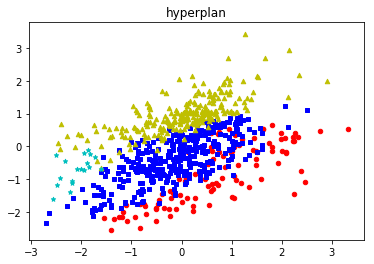

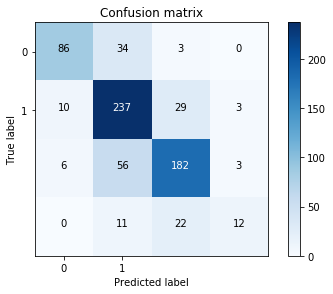

In [52]:
def train_lr(X, y , plot_roc=False):
    # grid search for svm
    model = svm.SVC(kernel='rbf')
    c_can = np.logspace(-2,2,10)
    gamma_can = np.logspace(-2,2,10)
    #lr = GridSearchCV(model, param_grid={'kernel':('linear', 'rbf'), 'C':c_can, 'gamma':gamma_can}, cv=10, n_jobs=8)
    
    # apply svm directly
    lr = svm.SVC(C=100,kernel="rbf",gamma=0.028)
    #lr = LogisticRegression(C=1, penalty='l1')
    #lr = RandomForestClassifier()
    #lr = RandomForestRegressor()

    #lr = XGBC 
    lr.fit(X_sample, y_sample)
    #print("best params:", lr.best_params_)
    y_prediction = lr.predict(X_v)
    # draw svm hyper plane
    plot_hyperplane(lr, X_v.values[:,1:3], y_prediction, draw_sv=False)
    
    # save the pred classes info
    #predict_result = pd.DataFrame(np.array(y_prediction).ravel(), columns=["y_prediction"])
    predict_result = pd.DataFrame()
    predict_result['y_prediction'] = y_prediction
    predict_result['user_id'] = dt_v.user_id
    #predict_result['user_id'] = predict_result['user_id'].astype('|S')
    #predict_result = predict_result.infer_objects()
    #print("predict_result.dtypes:", predict_result.dtypes)
    #print("predict_result:", predict_result.head())
    print("predict_result:", predict_result)

    calcConfMatrix(y_v, y_prediction)
    classifyReport(y_v, y_prediction)

        
train_lr(X, y, plot_roc=False)


('X_train.shape:', (520, 6))
('X_test.shape:', (174, 6))
('y_train.shape:', (520, 1))
('y_test.shape:', (174, 1))
[[19 10  2  0]
 [ 2 58  8  2]
 [ 1 10 51  0]
 [ 0  1  7  3]]
              precision    recall  f1-score   support

     class 0       0.86      0.61      0.72        31
     class 1       0.73      0.83      0.78        70
      class2       0.75      0.82      0.78        62
      class3       0.60      0.27      0.37        11

   micro avg       0.75      0.75      0.75       174
   macro avg       0.74      0.63      0.66       174
weighted avg       0.75      0.75      0.74       174

('kappa_score:', 0.6219875713636134)
('X_train.shape:', (520, 6))
('X_test.shape:', (174, 6))
('y_train.shape:', (520, 1))
('y_test.shape:', (174, 1))
[[16 13  2  0]
 [ 0 56 13  1]
 [ 1 13 46  2]
 [ 0  3  7  1]]
              precision    recall  f1-score   support

     class 0       0.94      0.52      0.67        31
     class 1       0.66      0.80      0.72        70
      class2   

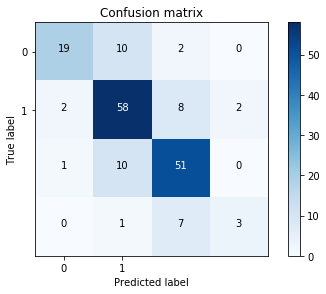

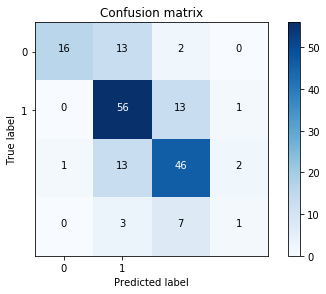

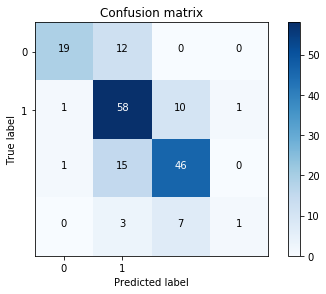

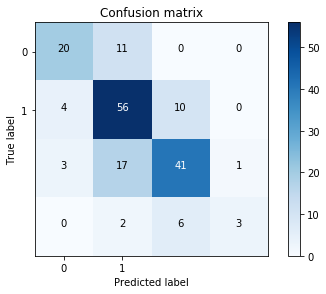

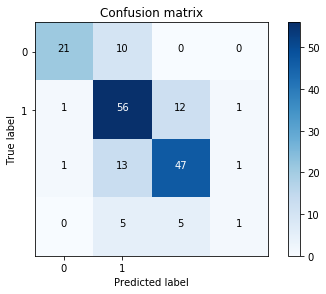

In [48]:
N_SPLITS = 10
TRAIN_SIZE = 0.7
TEST_SIZE_ORI = 0.3

def train_lr_fold(X, y , plot_roc=False):
    #X_train_ori, X_test_ori, y_train_ori, y_test_ori = train_test_split(X, y, test_size=TEST_SIZE_ORI)
    #print("X_train_ori.shape:", X_train_ori.shape)
    #print("X_test_ori.shape:", X_test_ori.shape)
    #print("y_train_ori.shape:", y_train_ori.shape)
    #print("y_test_ori.shape:", y_test_ori.shape)
    #print("positive samples in y_test_ori:", y_test_ori.y.sum())

    #sss = StratifiedShuffleSplit(n_splits=N_SPLITS, train_size=TRAIN_SIZE)
    sss = StratifiedShuffleSplit(n_splits=5,test_size=0.25,train_size=0.75,random_state=0)
    i = 0
    ##for train_index, test_index in sss.split(X_undersample, y_undersample):
    for (train_index, test_index), color in zip(sss.split(X_sample, y_sample), colors):
        X_train, X_test = X_sample.iloc[train_index], X_sample.iloc[test_index]
        y_train, y_test = y_sample.iloc[train_index], y_sample.iloc[test_index]
        print("X_train.shape:", X_train.shape)
        print("X_test.shape:", X_test.shape)
        print("y_train.shape:", y_train.shape)
        print("y_test.shape:", y_test.shape)

        #lr = DecisionTreeClassifier(criterion='entropy', max_depth=3)
        #lr = KNeighborsClassifier(n_neighbors=8, weights='distance')
        #lr = LogisticRegression(C=1, penalty='l1')
        #lr = RandomForestClassifier()
        #lr = RandomForestRegressor()
        #lr = XGBC
        lr = svm.SVC(C=100,kernel="rbf",gamma=0.028)  
        lr.fit(X_train, y_train.values.ravel())
        X_test_ori = X_test
        y_test_ori = y_test
        y_predict = lr.predict(X_test_ori)

        #lr = svm.SVC(kernel="rbf", probability=True, gamma=0.001)  
        #lr.fit(X_train, y_train.values.ravel())
        #y_predict = lr.predict_proba(X_test_ori)
        #y_predict = y_predict[:,1]

        #print("roc_auc:", metrics.roc_auc_score(y_test_ori, y_predict))
        #print("f1score:", metrics.f1_score(y_test_ori, y_predict, average='micro'))
        #print("precision:", metrics.precision_score(y_test_ori, y_predict, average='micro'))
        #print("recall:", metrics.recall_score(y_test_ori, y_predict, average='micro'))

        calcConfMatrix(y_test_ori, y_predict)
        classifyReport(y_test_ori, y_predict)
        calKappaScore(y_test_ori, y_predict)
        
        if plot_roc:
            plotROC(y_test_ori, y_predict, i, color)
            i += 1
    if plot_roc:
        plt.show()
        
train_lr_fold(X, y, plot_roc=False)